# Preparation

In [1]:
%matplotlib inline

In [2]:
# First step: pip install cohorts

In [3]:
import pandas as pd
from cohorts.random import random_cohort
from cohorts.functions import missense_snv_count, neoantigen_count
from cohorts.dataframe_loader import DataFrameLoader
from cohorts.variant_stats import variant_stats_from_variant

In [4]:
# False if we want to be able to re-run without re-generating the variants or the cohorts cache.
CLEAR_DATA = False

In [5]:
if CLEAR_DATA:
    # Clear any random variants generated from the last run.
    from shutil import rmtree
    from os import path, mkdir
    if path.exists("data"):
        rmtree("data")
    mkdir("data")
    
    # Clear any cached data generated from the last run.
    if path.exists("cache"):
        rmtree("cache")

In [6]:
cohort = random_cohort(size=30, cache_dir="cache", data_dir="data", 
                       min_random_variants=5, max_random_variants=20)

# Add a DataFrameLoader to join on separate PD-L1 data.
def load_pdl1():
    import random
    df_pdl1 = pd.DataFrame()
    df_pdl1["patient_id"] = [patient.id for patient in cohort]
    df_pdl1["PD-L1 Expression"] = [random.randint(0, 5) for i in range(len(cohort))]
    return df_pdl1
cohort.df_loaders.append(DataFrameLoader("pdl1", load_pdl1, join_on="patient_id"))

{'dataframe_hash': 5034499323281636309,
 'provenance_file_summary': {'cohorts': '0.4.2+1.g1b8048a',
                             'isovar': '0.0.6',
                             'mhctools': '0.3.1',
                             'numpy': '1.11.2',
                             'pandas': '0.19.1',
                             'pyensembl': '1.0.3',
                             'scipy': '0.18.1',
                             'topiary': '0.1.0',
                             'varcode': '0.5.10'}}


# Examples

Mann-Whitney test: U=70.0, p-value=0.04370335190103138 (two-sided)


MannWhitneyResults(U=70.0, p_value=0.043703351901, sided_str='two-sided')

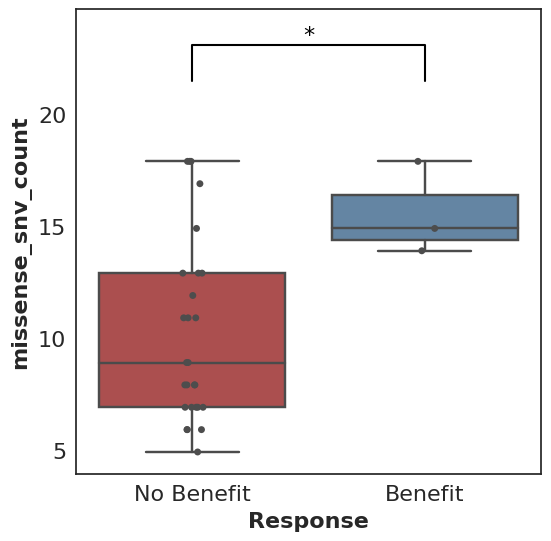

In [7]:
cohort.plot_benefit(on=missense_snv_count)

In [8]:
df = cohort.as_dataframe()

In [9]:
# Return a DataFrame with "neoantigen_count" as a column, in addition to user-specified patient data.
df_w_neoantigen_column = cohort.as_dataframe(on=neoantigen_count)

# Return a DataFrame with "Neoantigen Count" and "Missense SNV Count" as additional columns.
df_w_multiple_new_columns = cohort.as_dataframe(on={"Neoantigen Count": neoantigen_count, "Missense SNV Count": missense_snv_count})

# no condition 18
# with condition 12


<lifelines.StatisticalResult: 
Results
   null distribution: chi squared
   alpha: 0.95
   t 0: -1
   test: logrank
   df: 1

   __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
         0.29130 |              1.114 |  Cannot Reject Null |       False       
>

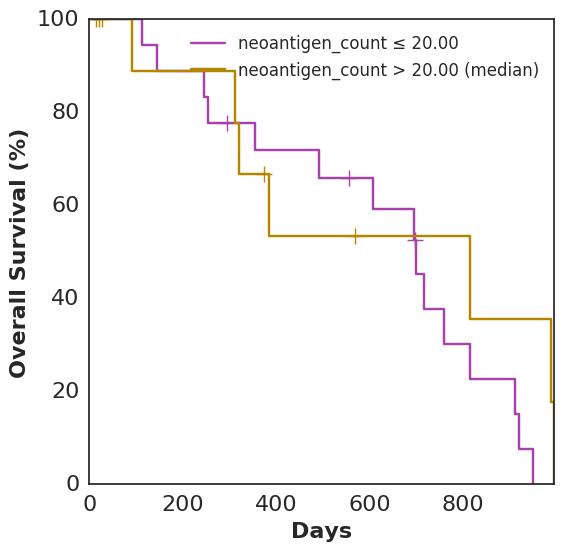

In [10]:
cohort.plot_survival(on=neoantigen_count)

# no condition 16
# with condition 14


<lifelines.StatisticalResult: 
Results
   null distribution: chi squared
   alpha: 0.95
   t 0: -1
   test: logrank
   df: 1

   __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
         0.53362 |              0.387 |  Cannot Reject Null |       False       
>

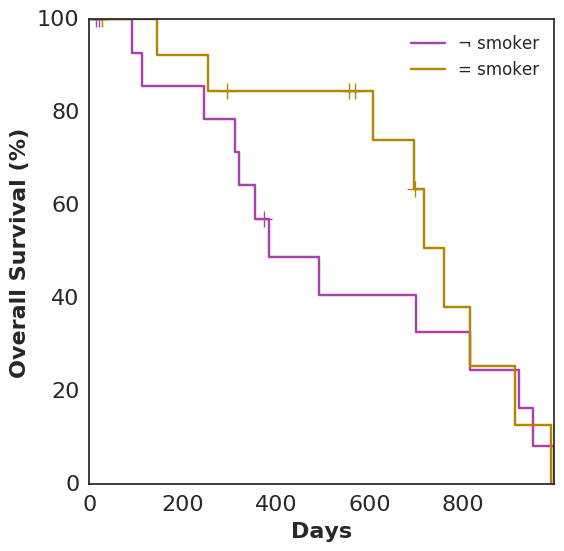

In [11]:
cohort.plot_survival(on="smoker")

inner join with pdl1: 30 to 30 rows
Mann-Whitney test: U=57.0, p-value=0.2610771762886286 (two-sided)
inner join with pdl1: 30 to 30 rows


CorrelationResults(coeff=-0.169573044098, p_value=0.370340131382, stat_func=pearsonr)

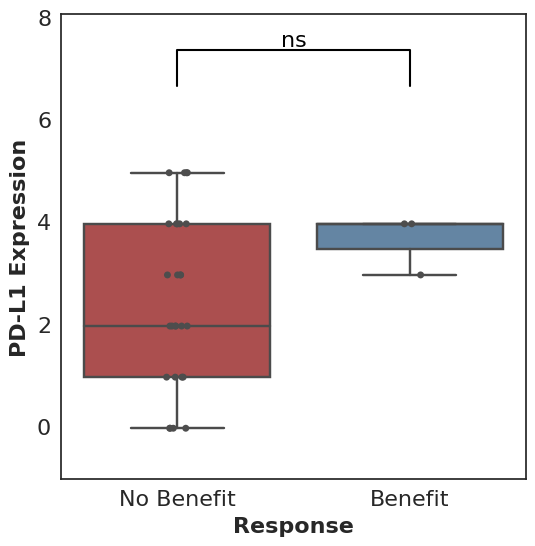

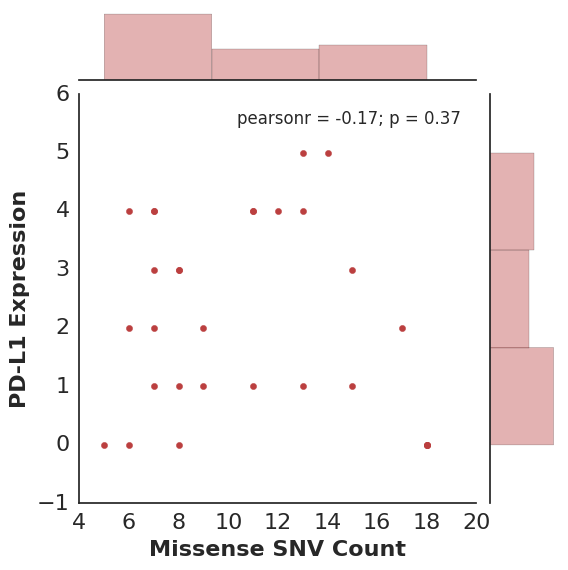

In [12]:
cohort.plot_benefit(on="PD-L1 Expression", join_with="pdl1")
cohort.plot_correlation(on={"Missense SNV Count": missense_snv_count,
                            "PD-L1 Expression": "PD-L1 Expression"},
                        join_with="pdl1")

In [13]:
# Dummy alternative filter.
def alternative_filter(filterable_variant):
    return True

# no condition 15
# with condition 15
# no condition 15
# with condition 15


<lifelines.StatisticalResult: 
Results
   null distribution: chi squared
   alpha: 0.95
   t 0: -1
   test: logrank
   df: 1

   __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
         0.46953 |              0.523 |  Cannot Reject Null |       False       
>

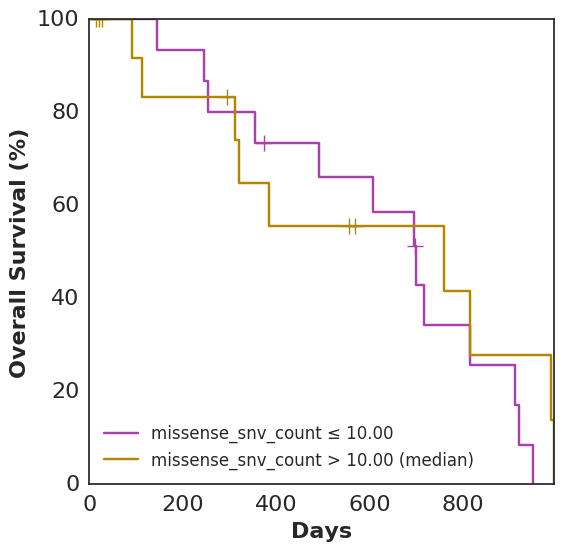

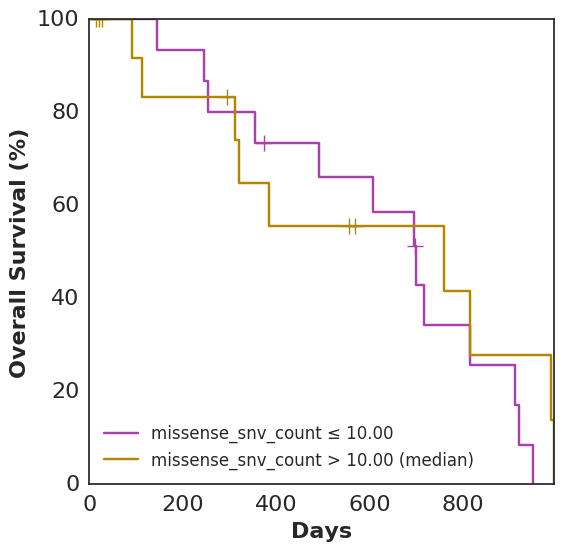

In [14]:
# Filter variants to those with at least 10 reads in the tumor sample.
def tumor_read_filter(filterable_variant):
    somatic_stats = variant_stats_from_variant(filterable_variant.variant,
                                               filterable_variant.variant_metadata)
    return somatic_stats.tumor_stats.depth >= 3

# Use a default filter function for the Cohort.
cohort.filter_fn = tumor_read_filter
cohort.plot_survival(on=missense_snv_count)

# ...or specify a filter function ad-hoc.
cohort.plot_survival(on=missense_snv_count, filter_fn=alternative_filter)